## Surface slope method



In [90]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import icepyx as ipx
import h5py
import geopandas as gpd
from pyproj import Transformer
import re
import glob
import ee
import geemap
import xarray as xr
from datetime import datetime,timedelta
import cartopy.crs as ccrs
# import salem
from pyproj import CRS

%matplotlib inline

In [4]:
### Functions 

## Reprojection using pyproj
def reproj(X, Y, source_epsg, target_epsg):
    lon = []
    lat = []
    transformer = Transformer.from_crs(source_epsg, target_epsg, always_xy=True)

    if len(X) == len(Y):
        for i in range(len(X)):
            lon1, lat1 = transformer.transform(X[i], Y[i])
            lon.append(lon1)
            lat.append(lat1)
    else:
        raise ValueError("X and Y must be of the same length.")
    return lon, lat


## Read ATL06 data and convert it to geodataframe
def read_atl06(f_name):
    f = h5py.File(f_name, "r")
    
    ## Following code come from ICESat-2 hackweek 2022 tutorial: https://github.com/ICESAT-2HackWeek/website2022/tree/main/book/tutorials/geospatial
    
    IS2_atl06_beams = []
    for key in f.keys():
        if key.startswith("gt"):
            # check if subsetted beam contains land ice data
            try:
                f[key]['land_ice_segments']['segment_id']
            except KeyError:
                pass
            else:
                IS2_atl06_beams.append(key)
            
    
    DEFAULT_GROUPS = []
    DEFAULT_GROUPS.append('bias_correction')
    DEFAULT_GROUPS.append('dem')
    DEFAULT_GROUPS.append('fit_statistics')
    DEFAULT_GROUPS.append('geophysical')
    DEFAULT_GROUPS.append('ground_track')
    
    groups=DEFAULT_GROUPS
    
    # output GeoDataFrame for ICESat-2 ATL06 variables
    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([],[]), crs="EPSG:4326")
    
    # read each input beam within the file
    for gtx in IS2_atl06_beams:
        # get each HDF5 variable in ICESat-2 land_ice_segments Group
        columns = {}
        for key,val in f[gtx]['land_ice_segments'].items():
            if isinstance(val, h5py.Dataset):
                if val.attrs.get('_FillValue'):
                    columns[key] = val[:].astype('f')
                    columns[key][val[:] == val.fillvalue] = np.nan
                else:
                    columns[key] = val[:]
            elif isinstance(val, h5py.Group) and (val.name.split('/')[-1] in groups):
                for k,v in val.items():
                    if v.attrs.get('_FillValue'):
                        columns[k] = v[:].astype('f')
                        columns[k][v[:] == v.fillvalue] = np.nan
                    else:
                        columns[k] = v[:]
        # number of segments
        n_seg = f[gtx]['land_ice_segments']['h_li'].size
        # fill value
        # generate derived variables
        columns['rgt'] = np.full((n_seg),f['orbit_info']['rgt'][0])
        columns['cycle_number'] = np.full((n_seg),f['orbit_info']['cycle_number'][0])
        BP,LR = re.findall(r'gt(\d)([lr])',gtx).pop()
        columns['BP'] = np.full((n_seg),int(BP))
        columns['LR'] = [LR]*n_seg
        beam_type = f[gtx].attrs['atlas_beam_type'].decode('utf-8')
        columns['beam_type'] = [beam_type]*n_seg
        columns['spot'] = np.full((n_seg),f[gtx].attrs['atlas_spot_number'])
        # convert from dictionary to geodataframe
        delta_time = (columns['delta_time']*1e9).astype('timedelta64[ns]')
        atlas_sdp_epoch = np.datetime64('2018-01-01T00:00:00Z')
        columns['time'] = gpd.pd.to_datetime(atlas_sdp_epoch + delta_time)
        # generate geometry column
        geometry = gpd.points_from_xy(columns['longitude'], columns['latitude'])
        del columns['longitude']
        del columns['latitude']
        # create Pandas DataFrame object
        df = gpd.pd.DataFrame(columns)
        # append to GeoDataFrame
        gdf = pd.concat([gdf, gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")])
    
    # Reproject to polar stereographic
    coords = np.stack(gdf.geometry.apply(lambda x: np.array(x.coords).ravel()))
    gdf["x"], gdf["y"] = reproj(coords[:, 0], coords[:, 1], "epsg:4326", "epsg:3413")
    # gdf["lon"] = coords[:, 0]
    # gdf["lat"] = coords[:, 1]

    return gdf

In [159]:
## Define ICESat-2 Data object to query
short_name = 'ATL11'
spatial_extent = [-61, 75, -58, 83]
date_range = ['2019-12-01','2020-03-01']

region_a = ipx.Query(short_name, spatial_extent, date_range, tracks='0582')
region_a.avail_granules(ids=True)

[['ATL11_058203_0323_006_08.h5', 'ATL11_058204_0323_006_08.h5']]

In [160]:
#download iceesat files
region_a.order_granules()
path = 'data/ATL11_Petermann/'
region_a.download_granules(path)

Total number of data order requests is  1  for  2  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000005734240
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000005734240 of  1  order(s) is downloaded.
Download complete


In [141]:
f_name = '/home/jovyan/ICESat-2_hackweek/GroundingLine-Greenland/data/ATL06_Petermann/processed_ATL11_020104_0323_006_08.h5'
f = h5py.File(f_name, "r")

In [245]:
f[pairtrack+'/cycle_stats/tide_ocean'][:]

<HDF5 dataset "tide_ocean": shape (2453, 21), type "<f4">

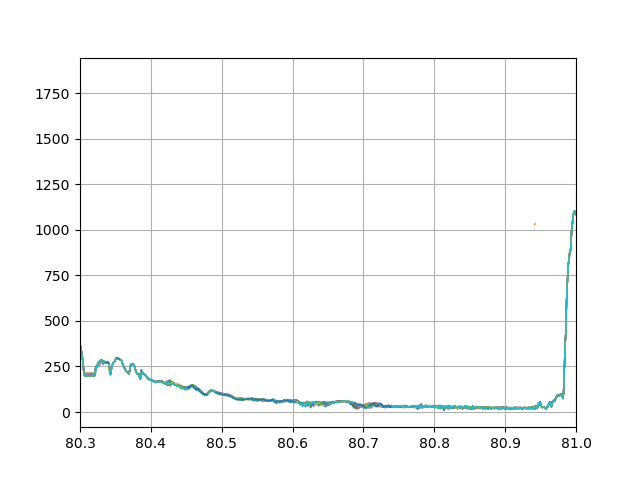

In [400]:
%matplotlib widget


f.keys()
pairtrack = 'pt3'
# f['pt2'].keys()
fig,axs = plt.subplots()
# f['pt2/ref_surf'].keys()
filenames = glob.glob('/home/jovyan/ICESat-2_hackweek/GroundingLine-Greenland/data/ATL11_Petermann/processed_ATL11_0582*.h5')
for k,filename in enumerate(filenames):
    # filename = filenames[0]
    f = h5py.File(filename, "r")
    if k==1:
        tidetemp = f[pairtrack+'/cycle_stats/tide_ocean'][:]
        final_tide = np.concatenate((tide,tidetemp))
        deltimetemp = f[pairtrack+'/delta_time'][:]
        final_time = np.concatenate((deltimetemp,deltime))
        latstemp = f[pairtrack]['latitude'][:]
        h_corr_temp = f[pairtrack]['h_corr'][:]
        h_corr_temp[h_corr_temp>1000000]=np.nan
        h_corr_final = np.concatenate((h_corr_temp,h_corr))
        final_lats = np.concatenate((latstemp,lats))
    lats = f[pairtrack]['latitude'][:]
    lons = f[pairtrack]['longitude']
    tide = f[pairtrack+'/cycle_stats/tide_ocean'][:]
    h_corr = f[pairtrack]['h_corr'][:]
    x_atc = f[pairtrack+'/ref_surf/x_atc'][:]
    h_corr[h_corr>1000000]=np.nan
    deltime = f[pairtrack+'/delta_time'][:]
    c=0
    for ind in np.arange(h_corr.shape[1]):
        axs.plot(lats,h_corr[:,ind],label = 'cycle' + str(ind),linewidth=1)
        c+=1
axs.set_xlim([80.3,81])
# axs2 = axs.twinx()
axs.grid()
# axs2.plot(final_lats,h_mean,color='red')
# axs.set_ylim([0,50])

plt.show()



array([80.00615517, 80.00668083, 80.00720649, ..., 81.15442885,
       81.15495164, 81.15547434])

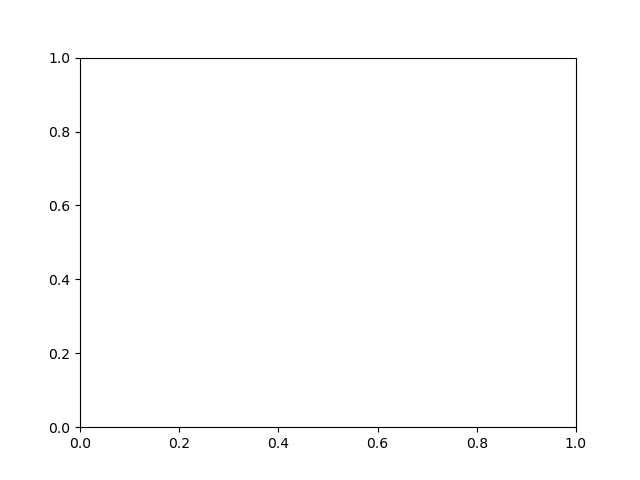

In [373]:
filename = filenames[0]
%matplotlib widget


f.keys()
pairtrack = 'pt3'
# f['pt2'].keys()
fig,axs = plt.subplots()
# f['pt2/ref_surf'].keys()
filenames = glob.glob('/home/jovyan/ICESat-2_hackweek/GroundingLine-Greenland/data/ATL11_Petermann/processed_ATL11_0582*.h5')
filename = filenames[0]
f = h5py.File(filename, "r")

lats = f[pairtrack]['latitude'][:]
lats




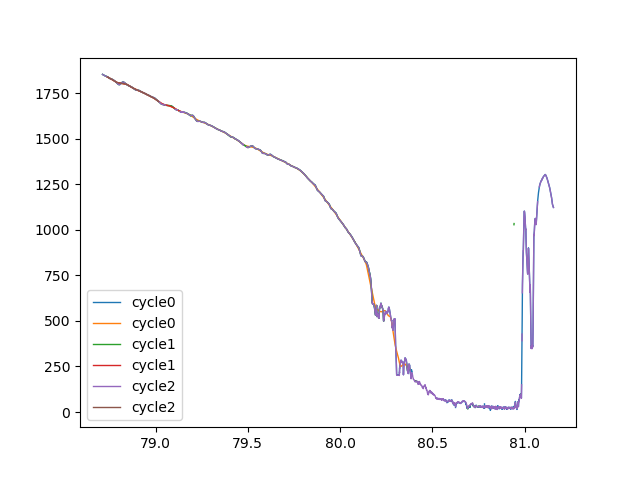

In [379]:
fig,axs = plt.subplots()
for ind in np.arange(3):
    axs.plot(final_lats,h_corr_final[:,ind],label = 'cycle' + str(ind),linewidth=1)
    axs.plot(final_lats[int(binsize/2)-1:-int(binsize/2)],running_mean(h_corr_final[:,ind],binsize),label = 'cycle' + str(ind),linewidth=1)
axs.legend()


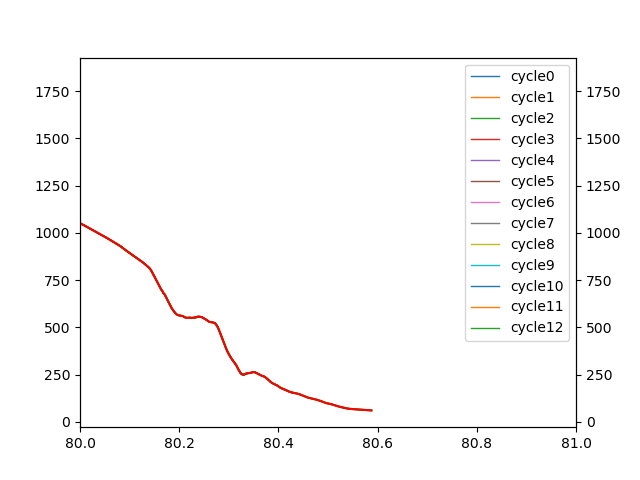

In [401]:
fig,axs = plt.subplots()
binsize = 100
for ind in np.arange(13):
    if ind==1:
        smoothies = h_corr_smooth
    h_corr_smooth = running_mean(h_corr_final[:,ind],binsize)
    if ind>1:
        smoothies = np.vstack((smoothies,h_corr_smooth))
    axs.plot(final_lats[int(binsize/2)-1:-int(binsize/2)],h_corr_smooth,label = 'cycle' + str(ind),linewidth=1)
axs2 = axs.twinx()
h_corr_smooth_mean = np.nanmean(smoothies,axis=0)
axs2.plot(final_lats[int(binsize/2)-1:-int(binsize/2)], h_corr_smooth_mean,color='red')
axs.set_xlim([80,81])
axs.plot(final_lats[int(meanbinsize/2)-1:-int(meanbinsize/2)],h_corr_smooth_mean,color='green')
axs.legend()

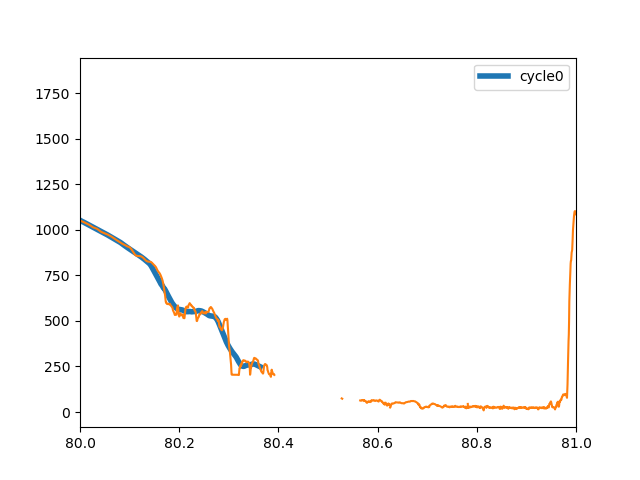

In [395]:
fig,axs = plt.subplots()
binsize = 100
ind=0
h_corr_smooth = running_mean(h_corr_final[:,ind],binsize)
axs.plot(final_lats[int(binsize/2)-1:-int(binsize/2)],h_corr_smooth,label = 'cycle' + str(ind),linewidth=4)
axs.plot(final_lats,h_corr_final[:,ind])
# axs2 = axs.twinx()
# h_corr_smooth_mean = np.nanmean(smoothies,axis=0)
# axs2.plot(final_lats[int(binsize/2)-1:-int(binsize/2)], np.gradient(h_corr_smooth_mean),color='red')
axs.set_xlim([80,81])
# axs.plot(final_lats[int(meanbinsize/2)-1:-int(meanbinsize/2)],h_corr_smooth_mean,color='green')
axs.legend()

In [257]:
# calculate elevation anomaly
# mean of all heights
# h_corr_final-= final_tide
h_mean = np.nanmean(h_corr_final,axis=1)
h_anomalies = np.zeros(h_corr_final.shape)
for ind in np.arange(h_corr_final.shape[1]):
    h_anomalies[:,ind] = h_corr_final[:,ind] - h_mean

In [344]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

smoothies.shape
h_corr_smooth_mean = np.nanmean(smoothies,axis=0)
h_corr_smooth_mean.shape
np.gradient(h_corr_smooth_mean).shape


(4539,)

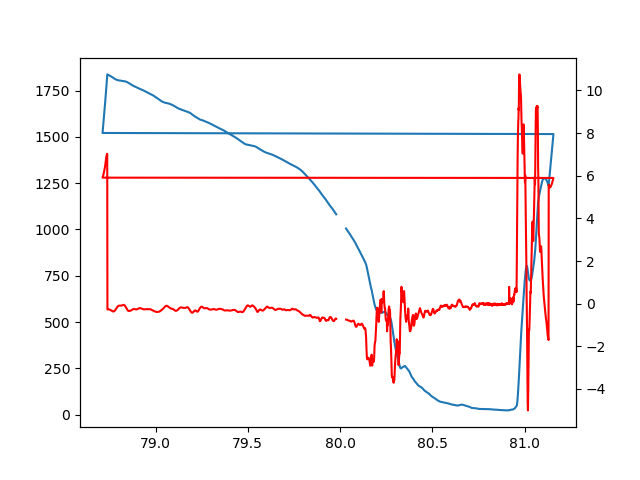

In [326]:
meanbinsize = 100
temp_h_mean = np.nanmean
h_corr_smooth = running_mean(h_mean,100)

fig,axs = plt.subplots()
axs.plot(final_lats[int(meanbinsize/2)-1:-int(meanbinsize/2)],h_corr_smooth)
axs2 = axs.twinx()
axs2.plot(final_lats[int(meanbinsize/2)-1:-int(meanbinsize/2)], np.gradient(h_corr_smooth),color='red')
# axs2.set_ylim([-1,1])

In [327]:
np.gradient(h_corr_smooth).shape

(4539,)

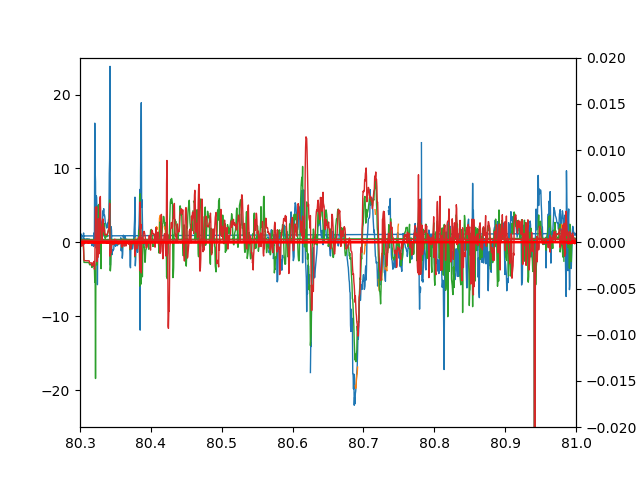

In [304]:

# f['pt2'].keys()
fig,axs = plt.subplots()
# f['pt2/ref_surf'].keys()

for ind in np.arange(4):
    axs.plot(final_lats,h_anomalies[:,ind],label = 'cycle' + str(ind),linewidth=1)
    # deltime = f['pt2/delta_time'][:]

axs.set_xlim([80.3,81])
axs.set_ylim([-25,25])
axs2 = axs.twinx()
axs2.plot(final_lats,np.nanmean(h_anomalies,axis=1),color='red')
axs2.set_ylim([-.02,.02])

plt.show()



80.11127649105903


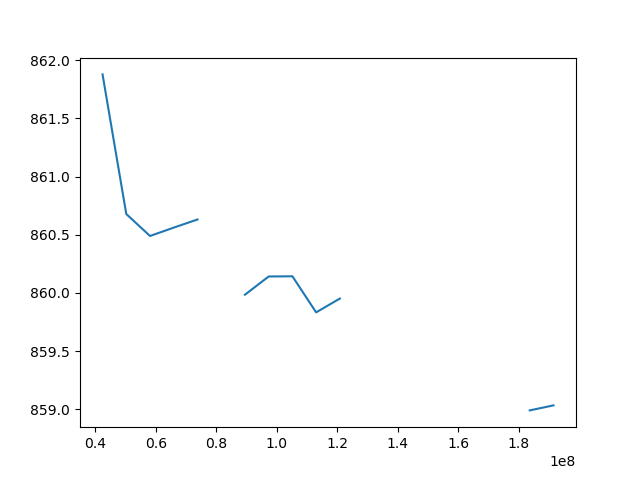

In [263]:
fig,ax = plt.subplots()
print(final_lats[200])
ax.plot(final_time[200,:],h_corr_final[200,:])


In [294]:
test=[datetime(2018,1,1)+timedelta(seconds=int(a)) for a in final_time[0,:]]
# temp = int(final_time[0,:][2])
# datetime(2018,1,1)+timedelta(seconds=temp)

datetime.datetime(2019, 11, 4, 0, 22, 30)

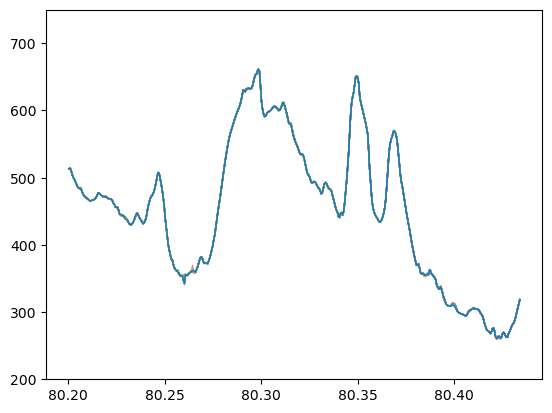

In [139]:
fig,axs = plt.subplots()
c=0
for ind in np.arange(h_corr.shape[1]):
    # print(ind)
    # t = datetime(2018,1,1)+ timedelta(seconds = time[0,ind])
    # axs.plot(x_atc,h_corr[:,ind],label = t.strftime('%m/%d/%Y'))
    axs.plot(lats,h_corr[:,ind],label = 'cycle' + str(ind),linewidth=1)
    c+=1
axs.set_ylim([200,750])
plt.show()

# axs.plot(x_atc,h_corr[:,10],label = 'cycle' + str(ind))

In [136]:
lats

array([80.20048699, 80.20101197, 80.20153696, 80.20206194, 80.20258692,
       80.2031119 , 80.20363688, 80.20416186, 80.20468684, 80.20521181,
       80.20573678, 80.20626175, 80.20678672, 80.20731169, 80.20783666,
       80.2083626 , 80.20888756, 80.20941156, 80.20993652, 80.21046148,
       80.21098645, 80.21151138, 80.21203631, 80.21256127, 80.21361124,
       80.21413619, 80.21466114, 80.21518609, 80.21571104, 80.21623599,
       80.21676094, 80.2172859 , 80.21781086, 80.21833677, 80.21886073,
       80.21938566, 80.21991061, 80.22043557, 80.2209605 , 80.22148638,
       80.22201131, 80.22253625, 80.22306118, 80.22358515, 80.22410911,
       80.22463404, 80.22515993, 80.22568486, 80.22621075, 80.22673567,
       80.22726059, 80.22778552, 80.22831044, 80.22883537, 80.22935934,
       80.22988521, 80.23041011, 80.23093502, 80.23145897, 80.23198389,
       80.23250882, 80.2330347 , 80.23408352, 80.23460843, 80.23513335,
       80.23565825, 80.23618411, 80.23670899, 80.23723389, 80.23

In [18]:
region_a.order_granules()

Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000005734231
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [19]:
path = 'data/ATL06_Petermann/'
region_a.download_granules(path)

Beginning download of zipped output...
Data request 5000005734231 of  1  order(s) is downloaded.
Download complete


In [6]:
## read in data
# f_name = "data/ATL06_Petermann/processed_ATL06_20190221122416_08410204_006_02.h5"
# ! h5ls {f_name}/gt2l/land_ice_segments

## Use year_oi as an example and read in all the ATL06 data in the defined date and spatial range

f_name_list = glob.glob("data/ATL06_Petermann/processed_ATL11*.h5")
year_oi = "2019"



gdf_dic = {}
for f_name in f_name_list[:10]:
    date_str = f_name.split("/")[-1].split("_")[2][:8]
    if date_str[:4]==year_oi:
        gdf = read_atl06(f_name) # Read ATL06 data and convert it to geodataframe
        gdf_dic[date_str] = gdf[["geometry", "geoid_h", "h_li", "h_li_sigma", "cycle_number", "BP", "LR", "beam_type", "time", "x", "y"]] # Subset using a list of interested parameters

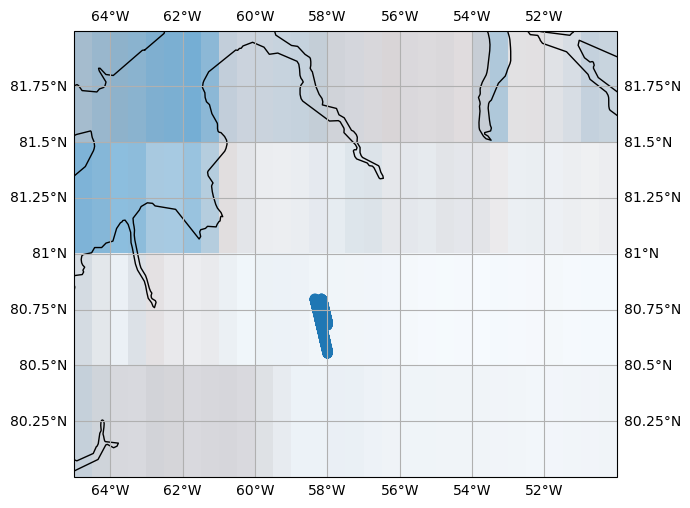

In [10]:
plt.close('all')
fig = plt.figure(figsize=(7,7)) #initiate plot
crs = salem.proj_to_cartopy(CRS.from_epsg(4326))
axs = plt.axes(projection=crs)
axs.coastlines(resolution='10m')
axs.gridlines(draw_labels=True)
axs.stock_img()
gdf_dic['20190221'].plot(ax=axs)
# plt.colorbar(sc1)
# axs.set_title(str(filename[-35:-27]))
axs.set_extent([-65,-50,80,82],crs=ccrs.PlateCarree())
# axs.set_extent([-60,20,60,87],crs=ccrs.PlateCarree())


In [ ]:
# gdf_dic is a dictionary of dataframes
# keys are the dates
gdf_dic
lat_list =[]
lon_list = []
for ind,file in enumerate(gdf_dic):
    lat_list.append(gdf_dic[file]['x'])
    lon_list.append(gdf_dic[file]['y'])
  

In [ ]:
lat_list[ind]